## Advanced Feature Selection

**Author**: Rajiv Shah

**Label**: Modeling Options

### Scope

The scope of this notebook is to provide instructions on how to do advanced feature selection using all of the models created during a run of DataRobot autopilot.

### Background

This is the procedure we are going to follow:

* Calculate the feature importance for each trained model
* Get the feature ranking for each trained model
* Get the ranking distribution for each feature across models
* Sort by mean rank and visualize

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com

It is assumed you already have a DataRobot <code>Project</code> object and a DataRobot <code>Model </code> object.

#### Import Libraries

In [1]:
import datarobot as dr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster')

I do not want to pick all of the models. I will ignore Blender, Auto-Tuned, and models trained with a small percentage of data. Lastly, I only care about models that were trained on 'Informative Features' but this can change depending on your needs.

In [3]:
featurelist_name = "Informative Features"
models = project.get_models()

for model in models:
    if (model.featurelist_name != featurelist_name 
        or "Blender" in model.model_type
        or model.sample_pct < 60
        or 'Auto-Tuned' in model.model_type):
        
        # Remove that model from the list
        models = [x for x in models if x.id != model.id]

Then, we will create a DataFrame of feature relative rank for the top 5 models.

In [4]:
all_impact = pd.DataFrame()
for model in models[0:5]:
    
    # This can take a minute (for each)
    feature_impact = model.get_or_request_feature_impact(max_wait=600)
    
    # Ready to be converted to DF
    df = pd.DataFrame(feature_impact)
    # Track model name and ID for bookkeeping purposes
    df['model_type'] = model.model_type
    df['model_id'] = model.id
    # By sorting and re-indexing, the new index becomes our 'ranking'
    df = df.sort_values(by='impactUnnormalized', ascending=False)
    df = df.reset_index(drop=True)
    df['rank'] = df.index.values
    
    # Add to our master list of all models' feature ranks
    all_impact = pd.concat([all_impact, df], ignore_index=True)

In [5]:
all_impact.head()

,featureName,impactNormalized,impactUnnormalized,redundantWith,model_type,model_id,rank
0,number_inpatient,1.000000,0.031445,None,eXtreme Gradient Boosted Trees Classifier with...,5e620be2d7c7a80c003d16a2,0
1,discharge_disposition_id,0.950723,0.029896,None,eXtreme Gradient Boosted Trees Classifier with...,5e620be2d7c7a80c003d16a2,1
2,medical_specialty,0.828289,0.026046,None,eXtreme Gradient Boosted Trees Classifier with...,5e620be2d7c7a80c003d16a2,2
3,number_diagnoses,0.609419,0.019163,None,eXtreme Gradient Boosted Trees Classifier with...,5e620be2d7c7a80c003d16a2,3
4,num_lab_procedures,0.543238,0.017082,None,eXtreme Gradient Boosted Trees Classifier with...,5e620be2d7c7a80c003d16a2,4


Now, we can find the N features with the highest median ranking and visualize the distributions:

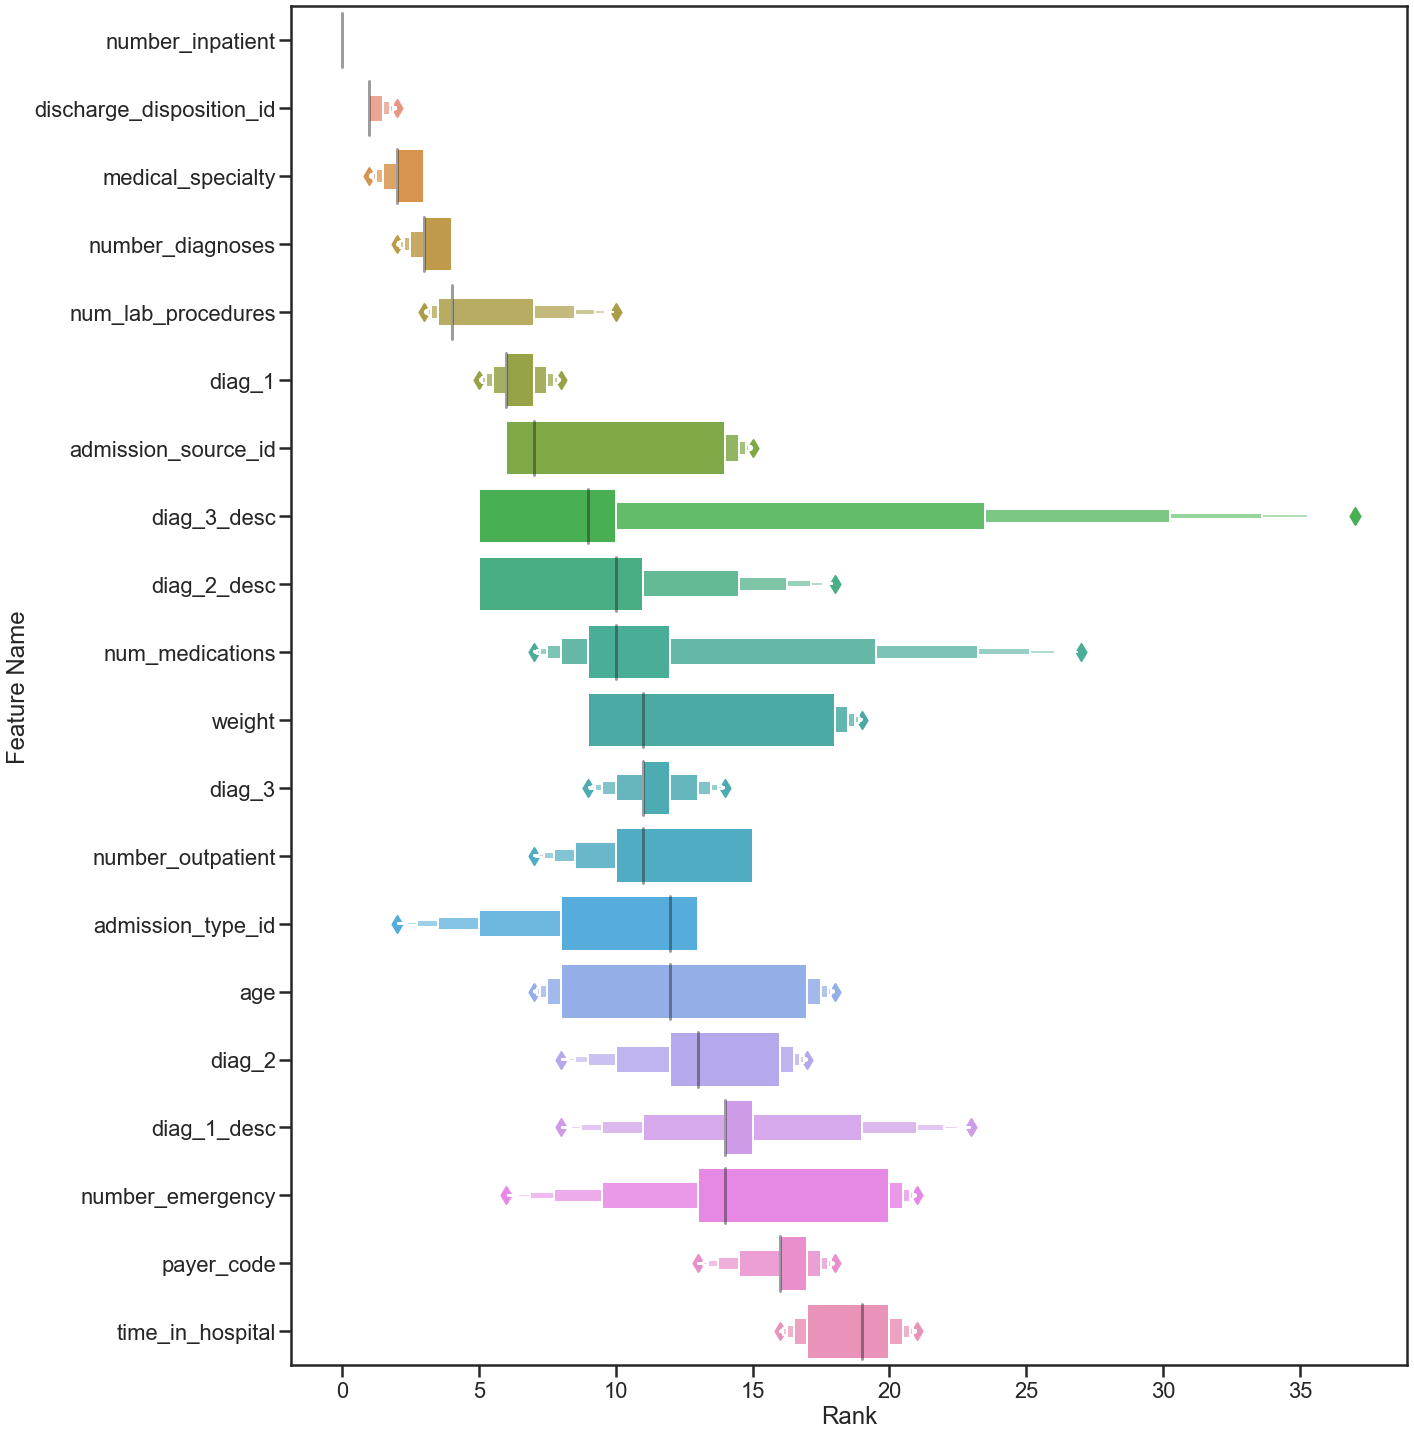

In [9]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

n_feats = 20
top_feats = list(all_impact
                 .groupby('featureName')
                 .median()
                 .sort_values('rank')
                 .head(n_feats)
                 .index
                 .values)

top_feat_impact = all_impact.query('featureName in @top_feats').copy()

fig, ax = plt.subplots(figsize=(20, 25))
sns.boxenplot(y='featureName', x='rank',
            data=top_feat_impact, order=top_feats,
            ax=ax, orient='h')
_ = ax.set_ylabel('Feature Name')
_ = ax.set_xlabel('Rank')

Finally, create a new feature list with the top features and re-run of DataRobot's Autopilot

In [ ]:
# ## Create new featurelist and run autopilot
featurelist = project.create_featurelist("consensus-top-features", list(top_feats))
featurelist_id = featurelist.id

project.start_autopilot(featurelist_id=featurelist_id)
project.wait_for_autopilot()